In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import sys
import optuna
import numpy as np
import matplotlib.pyplot as plt

# Готовим данные по маршрутам переводов

## Загружаем и чистим данные

Добавляем все необходимые датасеты.

In [193]:
# Путь к CSV файлу по маршрутам переводов
file_path_corridors = '/Users/artemsmirnov/Desktop/Учеба/Диплом Тиньк/Датасет/Значения по маршрутам.xlsx'

# Чтение CSV файла
corridors_of_transfers = pd.read_excel(file_path_corridors)

# Вывод первых 5 строк датасета
display(corridors_of_transfers.head())

,Region sender,Country sender,Region receiver,Country receiver,Volume of remitances (millions of US$),Number of migrants,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG] Country sender,Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD] Country sender,Adjusted net national income (current US$) [NY.ADJ.NNTY.CD] Country sender,Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG] Country sender,...,Voice and Accountability: Percentile Rank [VA.PER.RNK] Country receiver,"Voice and Accountability: Percentile Rank, Lower Bound of 90% Confidence Interval [VA.PER.RNK.LOWER] Country receiver","Voice and Accountability: Percentile Rank, Upper Bound of 90% Confidence Interval [VA.PER.RNK.UPPER] Country receiver",Voice and Accountability: Standard Error [VA.STD.ERR] Country receiver,"Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS] Country receiver","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS] Country receiver","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS] Country receiver","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS] Country receiver","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS] Country receiver","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS] Country receiver"
0,CIS,Russian Federation,Africa,Algeria,0.632037,785,4.426220,1.154248e+12,1.323904e+12,4.343765,...,20.772947,14.975845,25.603865,0.120992,24.17533,27.859685,27.211073,73.93685,67.707988,68.804558
1,Europe,France,Africa,Algeria,1446.724474,543,9.025649,2.152474e+12,2.472706e+12,8.714816,...,20.772947,14.975845,25.603865,0.120992,24.17533,27.859685,27.211073,73.93685,67.707988,68.804558
2,Europe,Germany,Africa,Algeria,23.440119,761,2.071027,2.970255e+12,3.575974e+12,2.027832,...,20.772947,14.975845,25.603865,0.120992,24.17533,27.859685,27.211073,73.93685,67.707988,68.804558
3,Europe,Italy,Africa,Algeria,18.531285,725,6.167560,1.542622e+12,1.755165e+12,6.716374,...,20.772947,14.975845,25.603865,0.120992,24.17533,27.859685,27.211073,73.93685,67.707988,68.804558
4,Europe,United Kingdom,Africa,Algeria,20.467688,782,NaN,NaN,NaN,NaN,...,20.772947,14.975845,25.603865,0.120992,24.17533,27.859685,27.211073,73.93685,67.707988,68.804558


In [194]:
print(corridors_of_transfers.shape)

(5135, 2472)


Удаляем столбцы, пустые более чем на 80%.

In [195]:
print(corridors_of_transfers.shape)

# Удаление столбцов с высоким процентом нулевых значений
threshold = 0.8  # Пороговое значение для определения столбцов с высоким процентом нулевых значений
corridors = corridors_of_transfers.dropna(thresh=threshold*len(corridors_of_transfers), axis=1)

print(corridors.shape)

(5135, 2472)
(5135, 1071)


Заполняем пустые строки средними значениями столбцов.

In [196]:
total_nan_counts = corridors.isna().sum().sum()
print(f"Total NaN values in the dataset before inserting avg to na: {total_nan_counts}")

# Заполнение всех пустых значений средними значениями столбцов
corridors = corridors.iloc[:, 4:].fillna(corridors.iloc[:, 4:].mean())

total_nan_counts = corridors.isna().sum().sum()
print(f"Total NaN values in the dataset after inserting avg to na: {total_nan_counts}")

Total NaN values in the dataset before inserting avg to na: 314506
Total NaN values in the dataset after inserting avg to na: 0


## Делим данные на train и test

Простое деление выборки

In [197]:
from sklearn.model_selection import train_test_split

# Определение признаков и целевой переменной
features = corridors.drop(['Volume of remitances (millions of US$)'], axis=1)
target = corridors['Volume of remitances (millions of US$)']

# Сначала разделим данные на тренировочный и временный (для последующего теста и валидации) наборы
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)

# Далее разделим временный набор на тестовый и валидационный наборы
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверка размеров наборов
print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {y_val.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")


Train shapes: (4108, 1066), (4108,)
Validation shapes: (513, 1066), (513,)
Test shapes: (514, 1066), (514,)


Деление нормализованной выборки

In [198]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
corridors_norm = scaler.fit_transform(corridors)

# Преобразование обратно в DataFrame и восстановление имен столбцов
corridors_norm = pd.DataFrame(corridors_norm, columns=corridors.columns)


# Определение признаков и целевой переменной
features_norm = corridors_norm.drop(['Volume of remitances (millions of US$)'], axis=1) 
target_norm = corridors_norm['Volume of remitances (millions of US$)']

# Сначала разделим данные на тренировочный и временный (для последующего теста и валидации) наборы
X_train_norm, X_temp_norm, y_train_norm, y_temp_norm = train_test_split(features_norm, target_norm, test_size=0.2, random_state=42)

# Далее разделим временный набор на тестовый и валидационный наборы
X_val_norm, X_test_norm, y_val_norm, y_test_norm = train_test_split(X_temp_norm, y_temp_norm, test_size=0.5, random_state=42)

# Проверка размеров наборов
print(f"Train shapes: {X_train_norm.shape}, {y_train_norm.shape}")
print(f"Validation shapes: {X_val_norm.shape}, {y_val_norm.shape}")
print(f"Test shapes: {X_test_norm.shape}, {y_test_norm.shape}")

Train shapes: (4108, 1066), (4108,)
Validation shapes: (513, 1066), (513,)
Test shapes: (514, 1066), (514,)


Деление на train и test с удалением коррелирующих фичей

In [199]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [200]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

628

In [201]:
X_train_corr = X_train.drop(corr_features,axis=1)
X_test_corr = X_test.drop(corr_features,axis=1)
X_val_corr = X_val.drop(corr_features,axis=1)

# Проверка размеров наборов
print(f"Train shapes: {X_train_corr.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val_corr.shape}, {y_val.shape}")
print(f"Test shapes: {X_test_corr.shape}, {y_test.shape}")

Train shapes: (4108, 438), (4108,)
Validation shapes: (513, 438), (513,)
Test shapes: (514, 438), (514,)


Деление на train и test нормализованных данных с удалением коррелирующих фичей

In [202]:
corr_features_norm = correlation(X_train_norm, 0.9)
len(set(corr_features_norm))

628

In [203]:
X_train_norm_corr = X_train_norm.drop(corr_features_norm,axis=1)
X_test_norm_corr = X_test_norm.drop(corr_features_norm,axis=1)
X_val_norm_corr = X_val_norm.drop(corr_features_norm,axis=1)

# Проверка размеров наборов
print(f"Train shapes: {X_train_norm_corr.shape}, {y_train_norm.shape}")
print(f"Validation shapes: {X_val_norm_corr.shape}, {y_val_norm.shape}")
print(f"Test shapes: {X_test_norm_corr.shape}, {y_test_norm.shape}")

Train shapes: (4108, 438), (4108,)
Validation shapes: (513, 438), (513,)
Test shapes: (514, 438), (514,)


Выбор лучших нормализованных фичей с помощью information gain

In [204]:
# Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=10)
selected_top_columns.fit(X_train_norm, y_train_norm)

SelectPercentile(score_func=<function mutual_info_regression at 0x7feff371e310>)

In [205]:
# Примените выбранные столбцы к исходным данным
X_train_norm_ig = X_train_norm.loc[:, selected_top_columns.get_support()]
X_test_norm_ig = X_test_norm.loc[:, selected_top_columns.get_support()]
X_val_norm_ig = X_val_norm.loc[:, selected_top_columns.get_support()]

# Проверка размеров наборов
print(f"Train shapes: {X_train_norm_ig.shape}, {y_train_norm.shape}")
print(f"Validation shapes: {X_val_norm_ig.shape}, {y_val_norm.shape}")
print(f"Test shapes: {X_test_norm_ig.shape}, {y_test_norm.shape}")

Train shapes: (4108, 107), (4108,)
Validation shapes: (513, 107), (513,)
Test shapes: (514, 107), (514,)


Удаление коррелирующих фичей

In [206]:
corr_features_norm_ig = correlation(X_train_norm_ig, 0.9)
len(set(corr_features_norm_ig))

68

In [207]:
X_train_norm_ig_corr = X_train_norm_ig.drop(corr_features_norm_ig,axis=1)
X_test_norm_ig_corr = X_test_norm_ig.drop(corr_features_norm_ig,axis=1)
X_val_norm_ig_corr = X_val_norm_ig.drop(corr_features_norm_ig,axis=1)

# Проверка размеров наборов
print(f"Train shapes: {X_train_norm_ig_corr.shape}, {y_train_norm.shape}")
print(f"Validation shapes: {X_val_norm_ig_corr.shape}, {y_val_norm.shape}")
print(f"Test shapes: {X_test_norm_ig_corr.shape}, {y_test_norm.shape}")

Train shapes: (4108, 39), (4108,)
Validation shapes: (513, 39), (513,)
Test shapes: (514, 39), (514,)


In [208]:
import pandas as pd

# Функция для удаления недопустимых символов из имен признаков
def clean_feature_names(features):
    return pd.DataFrame(features).rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('%', 'percent').replace('/', '_').replace(',', '').replace('.', '').replace(':', '').replace(' ', '_').replace('-', '_'))

# Применяем функцию к вашим данным
X_train_rep = clean_feature_names(X_train)
X_test_rep = clean_feature_names(X_test)
X_val_rep = clean_feature_names(X_val)
X_train_norm_rep = clean_feature_names(X_train_norm)
X_test_norm_rep = clean_feature_names(X_test_norm)
X_val_norm_rep = clean_feature_names(X_val_norm)
X_train_norm_ig_rep = clean_feature_names(X_train_norm_ig)
X_test_norm_ig_rep = clean_feature_names(X_test_norm_ig)
X_val_norm_ig_rep = clean_feature_names(X_val_norm_ig)
X_train_norm_corr_rep = clean_feature_names(X_train_norm_corr)
X_test_norm_corr_rep = clean_feature_names(X_test_norm_corr)
X_val_norm_corr_rep = clean_feature_names(X_val_norm_corr)
X_train_norm_ig_corr_rep = clean_feature_names(X_train_norm_ig_corr)
X_test_norm_ig_corr_rep = clean_feature_names(X_test_norm_ig_corr)
X_val_norm_ig_corr_rep = clean_feature_names(X_val_norm_ig_corr)

print("X_train_rep: ", X_train_rep.shape)
print("X_test_rep: ", X_test_rep.shape)
print("X_val_rep: ", X_val_rep.shape)
print()
print("X_train_norm_rep: ", X_train_norm_rep.shape)
print("X_test_norm_rep: ", X_test_norm_rep.shape)
print("X_val_norm_rep: ", X_val_norm_rep.shape)
print()
print("X_train_norm_ig_rep: ", X_train_norm_ig_rep.shape)
print("X_test_norm_ig_rep: ", X_test_norm_ig_rep.shape)
print("X_val_norm_ig_rep: ", X_val_norm_ig_rep.shape)
print()
print("X_train_norm_corr_rep: ", X_train_norm_corr_rep.shape)
print("X_test_norm_corr_rep: ", X_test_norm_corr_rep.shape)
print("X_val_norm_corr_rep: ", X_val_norm_corr_rep.shape)
print()
print("X_train_norm_ig_corr_rep: ", X_train_norm_ig_corr_rep.shape)
print("X_test_norm_ig_corr_rep: ", X_test_norm_ig_corr_rep.shape)
print("X_val_norm_ig_corr_rep: ", X_val_norm_ig_corr_rep.shape)

X_train_rep:  (4108, 1066)
X_test_rep:  (514, 1066)
X_val_rep:  (513, 1066)

X_train_norm_rep:  (4108, 1066)
X_test_norm_rep:  (514, 1066)
X_val_norm_rep:  (513, 1066)

X_train_norm_ig_rep:  (4108, 107)
X_test_norm_ig_rep:  (514, 107)
X_val_norm_ig_rep:  (513, 107)

X_train_norm_corr_rep:  (4108, 438)
X_test_norm_corr_rep:  (514, 438)
X_val_norm_corr_rep:  (513, 438)

X_train_norm_ig_corr_rep:  (4108, 39)
X_test_norm_ig_corr_rep:  (514, 39)
X_val_norm_ig_corr_rep:  (513, 39)


In [209]:
print('Target median: ', y_train.mean())
print('Target mean: ',y_train.median())

Target median:  125.41235985131422
Target mean:  3.5742345623553247


# Тренируем модели по маршрутам переводов

In [210]:
from sklearn.linear_model import LinearRegression

# Создание объекта линейной регрессии
linear_regression = LinearRegression()

# Обучение модели на изначальных данных
linear_regression.fit(X_train, y_train)
y_pred_linear = linear_regression.predict(X_test)

# Обучение модели на нормализованных данных
linear_regression.fit(X_train_norm, y_train_norm)
y_pred_linear_norm = linear_regression.predict(X_test_norm)

# Обучение модели на нормализованных и игнорируемых признаках
linear_regression.fit(X_train_norm_ig, y_train_norm)
y_pred_linear_norm_ig = linear_regression.predict(X_test_norm_ig)

# Обучение модели на нормализованных и скорректированных данных
linear_regression.fit(X_train_norm_corr, y_train_norm)
y_pred_linear_norm_corr = linear_regression.predict(X_test_norm_corr)

# Обучение модели на нормализованных, игнорируемых и скорректированных данных
linear_regression.fit(X_train_norm_ig_corr, y_train_norm)
y_pred_linear_norm_ig_corr = linear_regression.predict(X_test_norm_ig_corr)

# Инверсное преобразование нормализованных предсказаний обратно в исходную шкалу
scaler_target = StandardScaler()
scaler_target.fit(corridors[['Volume of remitances (millions of US$)']])

y_pred_linear_norm_original = scaler_target.inverse_transform(y_pred_linear_norm.reshape(-1, 1)).flatten()
y_test_norm_original = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()
y_pred_linear_norm_ig_original = scaler_target.inverse_transform(y_pred_linear_norm_ig.reshape(-1, 1)).flatten()
y_pred_linear_norm_corr_original = scaler_target.inverse_transform(y_pred_linear_norm_corr.reshape(-1, 1)).flatten()
y_pred_linear_norm_ig_corr_original = scaler_target.inverse_transform(y_pred_linear_norm_ig_corr.reshape(-1, 1)).flatten()

# Вывод метрик качества модели
print("linear_regression")
print(" ")
print("R^2: ", r2_score(y_test, y_pred_linear))
print("MAE: ", mean_absolute_error(y_test, y_pred_linear))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_linear))
print(" ")
print("linear_regression_norm")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_linear_norm_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_linear_norm_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_linear_norm_original))
print(" ")
print("linear_regression_norm_ig")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_linear_norm_ig_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_linear_norm_ig_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_linear_norm_ig_original))
print(" ")
print("linear_regression_norm_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_linear_norm_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_linear_norm_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_linear_norm_corr_original))
print(" ")
print("linear_regression_norm_ig_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_linear_norm_ig_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_linear_norm_ig_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_linear_norm_ig_corr_original))

linear_regression
 
R^2:  0.06836821288156636
MAE:  286.4207423542424
MAPE:  1161.1031801323459
 
linear_regression_norm
 
R^2:  -1.0254497779976699e+17
MAE:  9426903030.167006
MAPE:  23339450374.961098
 
linear_regression_norm_ig
 
R^2:  -0.030538694818072365
MAE:  217.03684848608646
MAPE:  557.4785449594887
 
linear_regression_norm_corr
 
R^2:  0.08705306600936091
MAE:  261.5000262572342
MAPE:  848.8185613686364
 
linear_regression_norm_ig_corr
 
R^2:  -0.12585306688409448
MAE:  218.29316429412034
MAPE:  670.2786616210904


In [211]:
from sklearn.linear_model import Ridge

# Создание объекта Ridge регрессии
ridge = Ridge(alpha=1.0, random_state=42)

# Обучение модели на изначальных данных
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Обучение модели на нормализованных данных
ridge.fit(X_train_norm, y_train_norm)
y_pred_ridge_norm = ridge.predict(X_test_norm)

# Обучение модели на нормализованных и игнорируемых признаках
ridge.fit(X_train_norm_ig, y_train_norm)
y_pred_ridge_norm_ig = ridge.predict(X_test_norm_ig)

# Обучение модели на нормализованных и скорректированных данных
ridge.fit(X_train_norm_corr, y_train_norm)
y_pred_ridge_norm_corr = ridge.predict(X_test_norm_corr)

# Обучение модели на нормализованных, игнорируемых и скорректированных данных
ridge.fit(X_train_norm_ig_corr, y_train_norm)
y_pred_ridge_norm_ig_corr = ridge.predict(X_test_norm_ig_corr)

# Инверсное преобразование нормализованных предсказаний обратно в исходную шкалу
scaler_target = StandardScaler()
scaler_target.fit(corridors[['Volume of remitances (millions of US$)']])

y_pred_ridge_norm_original = scaler_target.inverse_transform(y_pred_ridge_norm.reshape(-1, 1)).flatten()
y_test_norm_original = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()
y_pred_ridge_norm_ig_original = scaler_target.inverse_transform(y_pred_ridge_norm_ig.reshape(-1, 1)).flatten()
y_pred_ridge_norm_corr_original = scaler_target.inverse_transform(y_pred_ridge_norm_corr.reshape(-1, 1)).flatten()
y_pred_ridge_norm_ig_corr_original = scaler_target.inverse_transform(y_pred_ridge_norm_ig_corr.reshape(-1, 1)).flatten()

# Вывод метрик качества модели
print("ridge")
print(" ")
print("R^2: ", r2_score(y_test, y_pred_ridge))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_ridge))
print(" ")
print("ridge_norm")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_ridge_norm_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_ridge_norm_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_ridge_norm_original))
print(" ")
print("ridge_norm_ig")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_ridge_norm_ig_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_ridge_norm_ig_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_ridge_norm_ig_original))
print(" ")
print("ridge_norm_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_ridge_norm_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_ridge_norm_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_ridge_norm_corr_original))
print(" ")
print("ridge_norm_ig_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_ridge_norm_ig_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_ridge_norm_ig_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_ridge_norm_ig_corr_original))

ridge
 
R^2:  0.1177322202792811
MAE:  255.88264728871383
MAPE:  786.4162234791365
 
ridge_norm
 
R^2:  0.12237014792745526
MAE:  256.8141181010147
MAPE:  837.007371027698
 
ridge_norm_ig
 
R^2:  -0.06251590453570466
MAE:  212.91334855351087
MAPE:  655.9201573520251
 
ridge_norm_corr
 
R^2:  0.10333819120920529
MAE:  262.15649909563086
MAPE:  863.3416597021014
 
ridge_norm_ig_corr
 
R^2:  -0.1260727810181641
MAE:  218.26200018475532
MAPE:  668.7380578829443


In [212]:
from sklearn.linear_model import Lasso

# Создание объекта Lasso регрессии
lasso = Lasso(alpha=1.0, random_state=42)

# Обучение модели на изначальных данных
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Обучение модели на нормализованных данных
lasso.fit(X_train_norm, y_train_norm)
y_pred_lasso_norm = lasso.predict(X_test_norm)

# Обучение модели на нормализованных и игнорируемых признаках
lasso.fit(X_train_norm_ig, y_train_norm)
y_pred_lasso_norm_ig = lasso.predict(X_test_norm_ig)

# Обучение модели на нормализованных и скорректированных данных
lasso.fit(X_train_norm_corr, y_train_norm)
y_pred_lasso_norm_corr = lasso.predict(X_test_norm_corr)

# Обучение модели на нормализованных, игнорируемых и скорректированных данных
lasso.fit(X_train_norm_ig_corr, y_train_norm)
y_pred_lasso_norm_ig_corr = lasso.predict(X_test_norm_ig_corr)

y_pred_lasso_norm_original = scaler_target.inverse_transform(y_pred_lasso_norm.reshape(-1, 1)).flatten()
y_test_norm_original = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()
y_pred_lasso_norm_ig_original = scaler_target.inverse_transform(y_pred_lasso_norm_ig.reshape(-1, 1)).flatten()
y_pred_lasso_norm_corr_original = scaler_target.inverse_transform(y_pred_lasso_norm_corr.reshape(-1, 1)).flatten()
y_pred_lasso_norm_ig_corr_original = scaler_target.inverse_transform(y_pred_lasso_norm_ig_corr.reshape(-1, 1)).flatten()

# Вывод метрик качества модели
print("lasso")
print(" ")
print("R^2: ", r2_score(y_test, y_pred_lasso))
print("MAE: ", mean_absolute_error(y_test, y_pred_lasso))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_lasso))
print(" ")
print("lasso_norm")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_lasso_norm_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_lasso_norm_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_lasso_norm_original))
print(" ")
print("lasso_norm_ig")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_lasso_norm_ig_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_lasso_norm_ig_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_lasso_norm_ig_original))
print(" ")
print("lasso_norm_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_lasso_norm_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_lasso_norm_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_lasso_norm_corr_original))
print(" ")
print("lasso_norm_ig_corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_lasso_norm_ig_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_lasso_norm_ig_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_lasso_norm_ig_corr_original))

lasso
 
R^2:  0.11521662846681535
MAE:  257.0021840641634
MAPE:  835.5961903088005
 
lasso_norm
 
R^2:  -0.00038234214669641275
MAE:  183.47338936049664
MAPE:  1005.8144327797282
 
lasso_norm_ig
 
R^2:  -0.00038234214669641275
MAE:  183.47338936049664
MAPE:  1005.8144327797282
 
lasso_norm_corr
 
R^2:  -0.00038234214669641275
MAE:  183.47338936049664
MAPE:  1005.8144327797282
 
lasso_norm_ig_corr
 
R^2:  -0.00038234214669641275
MAE:  183.47338936049664
MAPE:  1005.8144327797282


/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e+09, tolerance: 4.800e+05



In [213]:
from sklearn.ensemble import RandomForestRegressor

# Создание объекта Random Forest регрессии
random_forest = RandomForestRegressor(random_state=42)

# Обучение модели на изначальных данных
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Обучение модели на нормализованных данных
random_forest.fit(X_train_norm, y_train_norm)
y_pred_rf_norm = random_forest.predict(X_test_norm)

# Обучение модели на нормализованных и игнорируемых признаках
random_forest.fit(X_train_norm_ig, y_train_norm)
y_pred_rf_norm_ig = random_forest.predict(X_test_norm_ig)

# Обучение модели на нормализованных и скорректированных данных
random_forest.fit(X_train_norm_corr, y_train_norm)
y_pred_rf_norm_corr = random_forest.predict(X_test_norm_corr)

# Обучение модели на нормализованных, игнорируемых и скорректированных данных
random_forest.fit(X_train_norm_ig_corr, y_train_norm)
y_pred_rf_norm_ig_corr = random_forest.predict(X_test_norm_ig_corr)

y_pred_rf_norm_original = scaler_target.inverse_transform(y_pred_rf_norm.reshape(-1, 1)).flatten()
y_test_norm_original = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()

y_pred_rf_norm_ig_original = scaler_target.inverse_transform(y_pred_rf_norm_ig.reshape(-1, 1)).flatten()
y_pred_rf_norm_corr_original = scaler_target.inverse_transform(y_pred_rf_norm_corr.reshape(-1, 1)).flatten()
y_pred_rf_norm_ig_corr_original = scaler_target.inverse_transform(y_pred_rf_norm_ig_corr.reshape(-1, 1)).flatten()

# Вывод метрик качества модели
print("Random Forest")
print(" ")
print("R^2: ", r2_score(y_test, y_pred_rf))
print("MAE: ", mean_absolute_error(y_test, y_pred_rf))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_rf))
print(" ")
print("Random Forest norm")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_rf_norm_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_rf_norm_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_rf_norm_original))
print(" ")
print("Random Forest norm ig")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_rf_norm_ig_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_rf_norm_ig_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_rf_norm_ig_original))
print(" ")
print("Random Forest norm corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_rf_norm_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_rf_norm_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_rf_norm_corr_original))
print(" ")
print("Random Forest norm ig corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_rf_norm_ig_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_rf_norm_ig_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_rf_norm_ig_corr_original))

Random Forest
 
R^2:  -0.3012901260033418
MAE:  148.77969909104363
MAPE:  34.3016062451874
 
Random Forest norm
 
R^2:  0.1454495005566846
MAE:  136.3932329916254
MAPE:  32.15572585954393
 
Random Forest norm ig
 
R^2:  0.026330699757394438
MAE:  188.2802478114035
MAPE:  327.88587383202145
 
Random Forest norm corr
 
R^2:  -0.22077883390648667
MAE:  146.14329395868742
MAPE:  39.59173086826959
 
Random Forest norm ig corr
 
R^2:  0.026255227539321857
MAE:  188.44292419142798
MAPE:  328.21147615098647


In [214]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Задаем сетку параметров для перебора
param_grid = {
    'n_estimators': [200], #50, 100, 200
    'max_depth': [10], #None, 10, 20
    'min_samples_split': [5], #2, 5, 10
    'min_samples_leaf': [2], #1, 2, 4
    'random_state': [42]
}

# Создаем объект Random Forest
random_forest = RandomForestRegressor()

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Обучаем модель
grid_search.fit(X_train_norm, y_train_norm)

# Выводим наилучшие параметры
print("Best Parameters:", grid_search.best_params_)

# Получаем наилучшую модель
best_random_forest = grid_search.best_estimator_

# Оцениваем на тестовых данных
y_pred_rf_norm = best_random_forest.predict(X_test_norm)

# Применение инверсного преобразования к предсказаниям
y_pred_rf_original_scale = scaler_target.inverse_transform(y_pred_rf_norm.reshape(-1, 1)).flatten()
y_test_original_scale = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()

# Оценка метрик модели на исходных данных
print("Random Forest on Normalized Data (Inverse Transformed Predictions)")
print("R^2:", r2_score(y_test_original_scale, y_pred_rf_original_scale))
print("MAE:", mean_absolute_error(y_test_original_scale, y_pred_rf_original_scale))
print("MAPE:", mean_absolute_percentage_error(y_test_original_scale, y_pred_rf_original_scale))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
Random Forest on Normalized Data (Inverse Transformed Predictions)
R^2: 0.5395465756297118
MAE: 124.73727067306123
MAPE: 115.80239673318214


In [217]:
from sklearn.svm import SVR

# Creating SVR model object
svr = SVR(kernel='rbf')  # You can choose different kernels like 'linear', 'poly', etc.

# Training the model on original data
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Training the model on normalized data
svr.fit(X_train_norm, y_train_norm)
y_pred_svr_norm = svr.predict(X_test_norm)

# Training the model on normalized and ignored features data
svr.fit(X_train_norm_ig, y_train_norm)
y_pred_svr_norm_ig = svr.predict(X_test_norm_ig)

# Training the model on normalized and corrected features data
svr.fit(X_train_norm_corr, y_train_norm)
y_pred_svr_norm_corr = svr.predict(X_test_norm_corr)

# Training the model on normalized, ignored, and corrected features data
svr.fit(X_train_norm_ig_corr, y_train_norm)
y_pred_svr_norm_ig_corr = svr.predict(X_test_norm_ig_corr)

# Инверсное преобразование нормализованных предсказаний обратно в исходную шкалу
y_pred_svr_norm_original = scaler_target.inverse_transform(y_pred_svr_norm.reshape(-1, 1)).flatten()
y_test_norm_original = scaler_target.inverse_transform(y_test_norm.values.reshape(-1, 1)).flatten()
y_pred_svr_norm_ig_original = scaler_target.inverse_transform(y_pred_svr_norm_ig.reshape(-1, 1)).flatten()
y_pred_svr_norm_corr_original = scaler_target.inverse_transform(y_pred_svr_norm_corr.reshape(-1, 1)).flatten()
y_pred_svr_norm_ig_corr_original = scaler_target.inverse_transform(y_pred_svr_norm_ig_corr.reshape(-1, 1)).flatten()

# Вывод метрик качества модели
print("SVR")
print(" ")
print("R^2: ", r2_score(y_test, y_pred_svr))
print("MAE: ", mean_absolute_error(y_test, y_pred_svr))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_svr))
print(" ")
print("SVR norm")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_svr_norm_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_svr_norm_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_svr_norm_original))
print(" ")
print("SVR norm ig")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_svr_norm_ig_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_svr_norm_ig_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_svr_norm_ig_original))
print(" ")
print("SVR norm corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_svr_norm_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_svr_norm_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_svr_norm_corr_original))
print(" ")
print("SVR norm ig corr")
print(" ")
print("R^2: ", r2_score(y_test_norm_original, y_pred_svr_norm_ig_corr_original))
print("MAE: ", mean_absolute_error(y_test_norm_original, y_pred_svr_norm_ig_corr_original))
print("MAPE: ", mean_absolute_percentage_error(y_test_norm_original, y_pred_svr_norm_ig_corr_original))


SVR
 
R^2:  -0.026406132655324877
MAE:  111.47280443993309
MAPE:  29.984945727703654
 
SVR norm
 
R^2:  0.17613140447133435
MAE:  136.12438003851625
MAPE:  610.1471659928023
 
SVR norm ig
 
R^2:  0.15228731668195583
MAE:  157.32888131357734
MAPE:  741.7984619131538
 
SVR norm corr
 
R^2:  0.21636724754733505
MAE:  137.79837535500934
MAPE:  587.5462922846804
 
SVR norm ig corr
 
R^2:  0.16352223234637842
MAE:  157.79719631534837
MAPE:  780.0138025505486


# CatBoostRegressor

In [247]:
# Применение select_features к тренировочному набору данных
model = CatBoostRegressor(random_state=15) #45 82

# Применение select_features к тренировочному набору данных
selection_result = model.select_features(
    X=X_train_rep,
    y=y_train,
    eval_set=[(clean_feature_names(X_val_rep), y_val)],
    features_for_select=X_train_rep.columns.tolist(),
    num_features_to_select=10,
    algorithm='RecursiveByShapValues',
    steps=None,
    shap_calc_type='Exact',
    train_final_model=False,
    verbose=False,
    plot=True,
    log_cout=sys.stdout,
    log_cerr=sys.stderr,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063568
Step #1 out of 1

bestTest = 569.8313103
bestIteration = 980

Shrink model to first 981 iterations.
Feature #318 eliminated
Feature #776 eliminated
Feature #577 eliminated
Feature #822 eliminated
Feature #913 eliminated
Feature #891 eliminated
Feature #912 eliminated
Feature #408 eliminated
Feature #837 eliminated
Feature #222 eliminated
Feature #64 eliminated
Feature #828 eliminated
Feature #850 eliminated
Feature #331 eliminated
Feature #364 eliminated
Feature #851 eliminated
Feature #354 eliminated
Feature #1032 eliminated
Feature #134 eliminated
Feature #316 eliminated
Feature #171 eliminated
Feature #701 eliminated
Feature #179 eliminated
Feature #400 eliminated
Feature #430 eliminated
Feature #729 eliminated
Feature #915 eliminated
Feature #805 eliminated
Feature #330 eliminated
Feature #666 eliminated
Feature #352 eliminated
Feature #409 eliminated
Feature #1038 eliminated
Feature #437 eliminated
Feature #544 eliminated
Feature #561 eliminated
Featu

Feature #21 eliminated
Feature #313 eliminated
Feature #536 eliminated
Feature #583 eliminated
Feature #789 eliminated
Feature #423 eliminated
Feature #456 eliminated
Feature #298 eliminated
Feature #832 eliminated
Feature #596 eliminated
Feature #414 eliminated
Feature #98 eliminated
Feature #519 eliminated
Feature #974 eliminated
Feature #63 eliminated
Feature #834 eliminated
Feature #1063 eliminated
Feature #863 eliminated
Feature #656 eliminated
Feature #301 eliminated
Feature #31 eliminated
Feature #819 eliminated
Feature #641 eliminated
Feature #339 eliminated
Feature #464 eliminated
Feature #49 eliminated
Feature #306 eliminated
Feature #694 eliminated
Feature #824 eliminated
Feature #153 eliminated
Feature #690 eliminated
Feature #1005 eliminated
Feature #944 eliminated
Feature #1001 eliminated
Feature #117 eliminated
Feature #1061 eliminated
Feature #34 eliminated
Feature #682 eliminated
Feature #759 eliminated
Feature #87 eliminated
Feature #286 eliminated
Feature #807 elimin

Feature #901 eliminated
Feature #1007 eliminated
Feature #220 eliminated
Feature #862 eliminated
Feature #799 eliminated
Feature #769 eliminated
Feature #32 eliminated
Feature #998 eliminated
Feature #348 eliminated
Feature #893 eliminated
Feature #314 eliminated
Feature #644 eliminated
Feature #572 eliminated
Feature #716 eliminated
Feature #276 eliminated
Feature #22 eliminated
Feature #721 eliminated
Feature #825 eliminated
Feature #14 eliminated
Feature #159 eliminated
Feature #44 eliminated
Feature #754 eliminated
Feature #255 eliminated
Feature #815 eliminated
Feature #1064 eliminated
Feature #967 eliminated
Feature #692 eliminated
Feature #989 eliminated
Feature #164 eliminated
Feature #267 eliminated
Feature #350 eliminated
Feature #802 eliminated
Feature #295 eliminated
Feature #119 eliminated
Feature #125 eliminated
Feature #148 eliminated
Feature #291 eliminated
Feature #753 eliminated
Feature #197 eliminated
Feature #908 eliminated
Feature #471 eliminated
Feature #950 elimi

Feature #852 eliminated
Feature #56 eliminated
Feature #43 eliminated
Feature #97 eliminated
Feature #703 eliminated
Feature #768 eliminated
Feature #136 eliminated
Feature #92 eliminated
Feature #696 eliminated
Feature #988 eliminated
Feature #917 eliminated
Feature #558 eliminated
Feature #146 eliminated
Feature #939 eliminated
Feature #982 eliminated
Feature #585 eliminated
Feature #642 eliminated
Feature #18 eliminated
Feature #198 eliminated
Feature #821 eliminated
Feature #859 eliminated
Feature #76 eliminated
Feature #169 eliminated
Feature #59 eliminated
Feature #185 eliminated
Feature #232 eliminated
Feature #574 eliminated
Feature #289 eliminated
Feature #33 eliminated
Feature #810 eliminated
Feature #811 eliminated


In [248]:
# Извлечение списка выбранных признаков
selected_features = selection_result['selected_features_names']

# Обновление тренировочного, валидационного и тестового наборов данных с выбранными признаками
X_train_catboost = X_train_rep[selected_features]
X_val_catboost = X_val_rep[selected_features]
X_test_catboost = X_test_rep[selected_features]

# Проверка размеров наборов после выбора признаков
print(f"Train shapes after feature selection: {X_train_catboost.shape}, {y_train.shape}")
print(f"Validation shapes after feature selection: {X_val_catboost.shape}, {y_val.shape}")
print(f"Test shapes after feature selection: {X_test_catboost.shape}, {y_test.shape}")

Train shapes after feature selection: (4108, 10), (4108,)
Validation shapes after feature selection: (513, 10), (513,)
Test shapes after feature selection: (514, 10), (514,)


In [237]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Целевая функция для Optuna
def objective(trial):
    # Определение гиперпараметров модели
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "random_state": 30
    }
    
    # Установка bagging_temperature только если bootstrap_type = "Bayesian"
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)

    model = CatBoostRegressor(**param)
    
    # Обучение модели
    model.fit(X_train_catboost, y_train, eval_set=(X_val_catboost, y_val), verbose=False, early_stopping_rounds=100)
    
    # Предсказание и оценка модели
    y_pred = model.predict(X_val_catboost)
    return mean_squared_error(y_val, y_pred, squared=False)

# Создание и запуск Optuna-исследования
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=400)

# Вывод лучших гиперпараметров
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Обучение модели с лучшими гиперпараметрами на полном тренировочном наборе
best_model = CatBoostRegressor(
    iterations=trial.params["iterations"],
    learning_rate=trial.params["learning_rate"],
    depth=trial.params["depth"],
    l2_leaf_reg=trial.params["l2_leaf_reg"],
    bootstrap_type=trial.params["bootstrap_type"],
    random_strength=trial.params["random_strength"],
    od_type=trial.params["od_type"],
    od_wait=trial.params["od_wait"],
    verbose=False,
    random_state=30
)

# Установка bagging_temperature только если bootstrap_type = "Bayesian"
if trial.params["bootstrap_type"] == "Bayesian":
    best_model.set_params(bagging_temperature=trial.params["bagging_temperature"])

best_model.fit(X_train_catboost, y_train)

# Проверка модели на тестовом наборе
y_pred_catboost = best_model.predict(X_test_catboost)

print("CatBoost")
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_pred_catboost))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_catboost))
print("R^2: ", r2_score(y_test, y_pred_catboost))

[I 2024-05-27 03:51:49,169] A new study created in memory with name: no-name-846a9461-29a6-42a9-b1db-014ab6049675
[I 2024-05-27 03:51:50,028] Trial 0 finished with value: 619.6622160536393 and parameters: {'iterations': 593, 'learning_rate': 0.004747610400905034, 'depth': 7, 'l2_leaf_reg': 1.4707639662957141e-08, 'bootstrap_type': 'Bernoulli', 'random_strength': 2.244716786730619e-05, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 0 with value: 619.6622160536393.
[I 2024-05-27 03:51:51,976] Trial 1 finished with value: 749.4257723015426 and parameters: {'iterations': 404, 'learning_rate': 0.002445931868632588, 'depth': 10, 'l2_leaf_reg': 39.23621819800012, 'bootstrap_type': 'MVS', 'random_strength': 2.3753116443327858e-08, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 619.6622160536393.
[I 2024-05-27 03:51:53,166] Trial 2 finished with value: 563.0481141338468 and parameters: {'iterations': 976, 'learning_rate': 0.032514259118085705, 'depth': 6, 'l2_leaf_reg': 0.

[I 2024-05-27 03:52:20,381] Trial 22 finished with value: 496.84844799980436 and parameters: {'iterations': 485, 'learning_rate': 0.03193623634232475, 'depth': 7, 'l2_leaf_reg': 0.00021235923962079962, 'bootstrap_type': 'Bayesian', 'random_strength': 1.910544563744255, 'od_type': 'IncToDec', 'od_wait': 14, 'bagging_temperature': 6.9511622655834815}. Best is trial 10 with value: 482.4859324020215.
[I 2024-05-27 03:52:21,429] Trial 23 finished with value: 516.4109218313312 and parameters: {'iterations': 634, 'learning_rate': 0.09789500543974673, 'depth': 8, 'l2_leaf_reg': 2.042813206404894e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.2867638779925247, 'od_type': 'IncToDec', 'od_wait': 11, 'bagging_temperature': 8.869166779465475}. Best is trial 10 with value: 482.4859324020215.
[I 2024-05-27 03:52:22,407] Trial 24 finished with value: 519.5097497370231 and parameters: {'iterations': 775, 'learning_rate': 0.05578744655294275, 'depth': 9, 'l2_leaf_reg': 0.04083736959904207, 'boo

[I 2024-05-27 03:52:39,809] Trial 44 finished with value: 520.566626396919 and parameters: {'iterations': 275, 'learning_rate': 0.06447311484068904, 'depth': 7, 'l2_leaf_reg': 0.009377246350538729, 'bootstrap_type': 'Bayesian', 'random_strength': 9.898675395595667, 'od_type': 'IncToDec', 'od_wait': 15, 'bagging_temperature': 3.005639994149143}. Best is trial 10 with value: 482.4859324020215.
[I 2024-05-27 03:52:40,890] Trial 45 finished with value: 582.7128715923337 and parameters: {'iterations': 578, 'learning_rate': 0.04652695966854137, 'depth': 8, 'l2_leaf_reg': 0.0004960579917941949, 'bootstrap_type': 'Bernoulli', 'random_strength': 7.493775640884439e-08, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 10 with value: 482.4859324020215.
[I 2024-05-27 03:52:41,603] Trial 46 finished with value: 511.3311566477633 and parameters: {'iterations': 423, 'learning_rate': 0.038224883980405, 'depth': 7, 'l2_leaf_reg': 0.374084586976613, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0011

[I 2024-05-27 03:53:05,937] Trial 66 finished with value: 572.2506040148304 and parameters: {'iterations': 687, 'learning_rate': 0.0032667851616534687, 'depth': 7, 'l2_leaf_reg': 2.232456707866297e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 3.8153385851813644, 'od_type': 'IncToDec', 'od_wait': 11, 'bagging_temperature': 9.597078207607897}. Best is trial 53 with value: 445.6846598291607.
[I 2024-05-27 03:53:07,300] Trial 67 finished with value: 524.7404223492331 and parameters: {'iterations': 805, 'learning_rate': 0.06054277577075091, 'depth': 10, 'l2_leaf_reg': 9.323217769362339e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.2644024037923677, 'od_type': 'IncToDec', 'od_wait': 30, 'bagging_temperature': 9.400517278780653}. Best is trial 53 with value: 445.6846598291607.
[I 2024-05-27 03:53:08,601] Trial 68 finished with value: 444.7185545863277 and parameters: {'iterations': 888, 'learning_rate': 0.04203859556607913, 'depth': 8, 'l2_leaf_reg': 5.297360937716604e-07, '

[I 2024-05-27 03:53:28,016] Trial 87 finished with value: 499.452935447601 and parameters: {'iterations': 966, 'learning_rate': 0.04273321519939049, 'depth': 5, 'l2_leaf_reg': 1.1920065012110208e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 4.138900467078801, 'od_type': 'Iter', 'od_wait': 21, 'bagging_temperature': 8.47982178064579}. Best is trial 68 with value: 444.7185545863277.
[I 2024-05-27 03:53:28,605] Trial 88 finished with value: 494.8238915444628 and parameters: {'iterations': 764, 'learning_rate': 0.05937946982834596, 'depth': 6, 'l2_leaf_reg': 3.636620137948581e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1393110628078955, 'od_type': 'IncToDec', 'od_wait': 25, 'bagging_temperature': 8.14548883544362}. Best is trial 68 with value: 444.7185545863277.
[I 2024-05-27 03:53:29,565] Trial 89 finished with value: 477.234404770438 and parameters: {'iterations': 857, 'learning_rate': 0.09310558757842999, 'depth': 8, 'l2_leaf_reg': 5.189974530047957e-06, 'bootstrap_t

[I 2024-05-27 03:53:48,333] Trial 108 finished with value: 491.1360837916654 and parameters: {'iterations': 762, 'learning_rate': 0.03792328149756077, 'depth': 8, 'l2_leaf_reg': 2.4477125583764585e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00016297803492108253, 'od_type': 'IncToDec', 'od_wait': 26, 'bagging_temperature': 9.984490101154059}. Best is trial 68 with value: 444.7185545863277.
[I 2024-05-27 03:53:48,750] Trial 109 finished with value: 507.61418968460225 and parameters: {'iterations': 818, 'learning_rate': 0.07984021485332338, 'depth': 7, 'l2_leaf_reg': 0.000318622471156056, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7589274651973582, 'od_type': 'IncToDec', 'od_wait': 20, 'bagging_temperature': 9.613133596791164}. Best is trial 68 with value: 444.7185545863277.
[I 2024-05-27 03:53:50,474] Trial 110 finished with value: 555.8302999630795 and parameters: {'iterations': 945, 'learning_rate': 0.05780824549428324, 'depth': 8, 'l2_leaf_reg': 5.067439892489458e-

[I 2024-05-27 03:54:11,269] Trial 129 finished with value: 538.4404000969882 and parameters: {'iterations': 640, 'learning_rate': 0.09043254834447144, 'depth': 8, 'l2_leaf_reg': 2.929154638771031e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 2.335955721136437, 'od_type': 'IncToDec', 'od_wait': 19, 'bagging_temperature': 3.6237993368617576}. Best is trial 127 with value: 444.3633738169791.
[I 2024-05-27 03:54:13,106] Trial 130 finished with value: 513.9433811698962 and parameters: {'iterations': 795, 'learning_rate': 0.02975464994870472, 'depth': 8, 'l2_leaf_reg': 1.5029594274426843e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 5.9848200818517014, 'od_type': 'IncToDec', 'od_wait': 22, 'bagging_temperature': 9.407328290215707}. Best is trial 127 with value: 444.3633738169791.
[I 2024-05-27 03:54:14,583] Trial 131 finished with value: 464.49129475913946 and parameters: {'iterations': 952, 'learning_rate': 0.07390432512807348, 'depth': 8, 'l2_leaf_reg': 1.7170882970467106e-

[I 2024-05-27 03:54:38,065] Trial 150 finished with value: 458.643671058111 and parameters: {'iterations': 645, 'learning_rate': 0.06698732823351024, 'depth': 8, 'l2_leaf_reg': 3.2228450681430493e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.5575595809977358, 'od_type': 'IncToDec', 'od_wait': 14, 'bagging_temperature': 6.4427136324689345}. Best is trial 127 with value: 444.3633738169791.
[I 2024-05-27 03:54:38,858] Trial 151 finished with value: 518.2383208320107 and parameters: {'iterations': 634, 'learning_rate': 0.06485677850895315, 'depth': 8, 'l2_leaf_reg': 3.437528761419579e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.8243943973579304, 'od_type': 'IncToDec', 'od_wait': 14, 'bagging_temperature': 6.4323038896372555}. Best is trial 127 with value: 444.3633738169791.
[I 2024-05-27 03:54:39,728] Trial 152 finished with value: 506.44766407869946 and parameters: {'iterations': 705, 'learning_rate': 0.06817018171897926, 'depth': 8, 'l2_leaf_reg': 8.005529706737761e-

[I 2024-05-27 03:55:02,152] Trial 171 finished with value: 489.60028882717177 and parameters: {'iterations': 494, 'learning_rate': 0.03514765766068992, 'depth': 8, 'l2_leaf_reg': 4.052600907319016e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 7.044059728265087, 'od_type': 'IncToDec', 'od_wait': 16, 'bagging_temperature': 6.001517823211553}. Best is trial 157 with value: 433.8455580310365.
[I 2024-05-27 03:55:03,227] Trial 172 finished with value: 519.743716369945 and parameters: {'iterations': 511, 'learning_rate': 0.02639557419629214, 'depth': 8, 'l2_leaf_reg': 1.448447031754094e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 4.157613972709826, 'od_type': 'IncToDec', 'od_wait': 18, 'bagging_temperature': 6.161260972271388}. Best is trial 157 with value: 433.8455580310365.
[I 2024-05-27 03:55:04,385] Trial 173 finished with value: 539.4955463041883 and parameters: {'iterations': 562, 'learning_rate': 0.03188610604738125, 'depth': 8, 'l2_leaf_reg': 5.368553527663493e-07, '

[I 2024-05-27 03:55:28,148] Trial 192 finished with value: 461.8628882860727 and parameters: {'iterations': 574, 'learning_rate': 0.02002502246293613, 'depth': 8, 'l2_leaf_reg': 1.342777111721015e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 9.632578900604132, 'od_type': 'IncToDec', 'od_wait': 13, 'bagging_temperature': 5.973444848197607}. Best is trial 157 with value: 433.8455580310365.
[I 2024-05-27 03:55:29,084] Trial 193 finished with value: 478.0697990755035 and parameters: {'iterations': 449, 'learning_rate': 0.020750967322482584, 'depth': 8, 'l2_leaf_reg': 5.44756004742754e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 9.922829176052486, 'od_type': 'IncToDec', 'od_wait': 14, 'bagging_temperature': 5.969352045576853}. Best is trial 157 with value: 433.8455580310365.
[I 2024-05-27 03:55:30,378] Trial 194 finished with value: 506.5319280843023 and parameters: {'iterations': 628, 'learning_rate': 0.023671768574174273, 'depth': 8, 'l2_leaf_reg': 2.897874687871297e-07, 

[I 2024-05-27 03:55:53,049] Trial 213 finished with value: 500.5484907908958 and parameters: {'iterations': 587, 'learning_rate': 0.032468353422279876, 'depth': 8, 'l2_leaf_reg': 2.5604615634488873e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 7.001002454217305, 'od_type': 'Iter', 'od_wait': 15, 'bagging_temperature': 6.522150208296978}. Best is trial 204 with value: 426.45394865742804.
[I 2024-05-27 03:55:54,592] Trial 214 finished with value: 502.40454622822233 and parameters: {'iterations': 564, 'learning_rate': 0.03904568242763259, 'depth': 8, 'l2_leaf_reg': 5.271900721652117e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 4.303597584117681, 'od_type': 'IncToDec', 'od_wait': 17, 'bagging_temperature': 6.321038098512225}. Best is trial 204 with value: 426.45394865742804.
[I 2024-05-27 03:55:56,050] Trial 215 finished with value: 501.49676721607875 and parameters: {'iterations': 620, 'learning_rate': 0.03423877695861051, 'depth': 8, 'l2_leaf_reg': 9.069645154269584e-07,

[I 2024-05-27 03:56:20,802] Trial 234 finished with value: 516.1776529269089 and parameters: {'iterations': 598, 'learning_rate': 0.03324434756291249, 'depth': 8, 'l2_leaf_reg': 4.5538905810576877e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 7.089272039495259, 'od_type': 'Iter', 'od_wait': 16, 'bagging_temperature': 5.335381924445579}. Best is trial 204 with value: 426.45394865742804.
[I 2024-05-27 03:56:22,383] Trial 235 finished with value: 443.0055928383726 and parameters: {'iterations': 571, 'learning_rate': 0.030673710304930282, 'depth': 8, 'l2_leaf_reg': 7.340425471235322e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 9.862957917109195, 'od_type': 'Iter', 'od_wait': 14, 'bagging_temperature': 6.2810872712461245}. Best is trial 204 with value: 426.45394865742804.
[I 2024-05-27 03:56:23,811] Trial 236 finished with value: 495.66928659151176 and parameters: {'iterations': 717, 'learning_rate': 0.040103290846460644, 'depth': 8, 'l2_leaf_reg': 8.152620858966104e-07, 'b

[I 2024-05-27 03:56:53,216] Trial 255 finished with value: 456.5054957942897 and parameters: {'iterations': 654, 'learning_rate': 0.03301116329689747, 'depth': 8, 'l2_leaf_reg': 1.3206265395647083e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 9.945598282916967, 'od_type': 'Iter', 'od_wait': 18, 'bagging_temperature': 5.978642473543121}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:56:54,627] Trial 256 finished with value: 499.7712224099946 and parameters: {'iterations': 681, 'learning_rate': 0.029636111299810693, 'depth': 8, 'l2_leaf_reg': 1.0559030018740507e-06, 'bootstrap_type': 'Bernoulli', 'random_strength': 6.589706986768402, 'od_type': 'Iter', 'od_wait': 17}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:56:55,140] Trial 257 finished with value: 586.6025544611684 and parameters: {'iterations': 215, 'learning_rate': 0.00848942397714296, 'depth': 8, 'l2_leaf_reg': 5.193766126778577e-07, 'bootstrap_type': 'Bayesian', 'random_strength'

[I 2024-05-27 03:57:24,610] Trial 276 finished with value: 571.5143138561275 and parameters: {'iterations': 639, 'learning_rate': 0.03647974461228089, 'depth': 8, 'l2_leaf_reg': 1.609040384366316e-06, 'bootstrap_type': 'Bernoulli', 'random_strength': 1.1817356259434598e-06, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:57:26,503] Trial 277 finished with value: 485.16108132610526 and parameters: {'iterations': 761, 'learning_rate': 0.0335448837545889, 'depth': 8, 'l2_leaf_reg': 5.454180120149544e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 6.913938606749848, 'od_type': 'Iter', 'od_wait': 15, 'bagging_temperature': 5.1767723320113195}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:57:28,059] Trial 278 finished with value: 445.84742428947067 and parameters: {'iterations': 666, 'learning_rate': 0.03906523084648271, 'depth': 8, 'l2_leaf_reg': 1.666625397672854e-07, 'bootstrap_type': 'Bayesian', 'random_stren

[I 2024-05-27 03:57:56,266] Trial 297 finished with value: 484.76689969070037 and parameters: {'iterations': 711, 'learning_rate': 0.03701798115647043, 'depth': 8, 'l2_leaf_reg': 1.0725605387193518e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 6.912959385895902, 'od_type': 'Iter', 'od_wait': 16, 'bagging_temperature': 5.823250436173442}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:57:57,607] Trial 298 finished with value: 614.5585565686737 and parameters: {'iterations': 646, 'learning_rate': 0.002659332512983715, 'depth': 8, 'l2_leaf_reg': 0.0006355408279419413, 'bootstrap_type': 'Bayesian', 'random_strength': 2.9701821511598054, 'od_type': 'Iter', 'od_wait': 17, 'bagging_temperature': 1.405595265419719}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:57:58,991] Trial 299 finished with value: 452.4948153835686 and parameters: {'iterations': 668, 'learning_rate': 0.041049728395777724, 'depth': 8, 'l2_leaf_reg': 8.116289468164624e-07, 'boo

[I 2024-05-27 03:58:26,343] Trial 318 finished with value: 501.21310827204985 and parameters: {'iterations': 661, 'learning_rate': 0.049427012608872334, 'depth': 8, 'l2_leaf_reg': 1.15351331225409e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 6.949738033083362, 'od_type': 'Iter', 'od_wait': 32, 'bagging_temperature': 5.041618708438702}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:58:27,898] Trial 319 finished with value: 528.141527958562 and parameters: {'iterations': 674, 'learning_rate': 0.03291842868497828, 'depth': 8, 'l2_leaf_reg': 4.102552936903196e-07, 'bootstrap_type': 'MVS', 'random_strength': 2.1996366604950146, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:58:28,866] Trial 320 finished with value: 517.6328492161541 and parameters: {'iterations': 357, 'learning_rate': 0.04038724091510866, 'depth': 8, 'l2_leaf_reg': 7.416877879624292e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0101

[I 2024-05-27 03:58:54,130] Trial 339 finished with value: 563.8416078830631 and parameters: {'iterations': 108, 'learning_rate': 0.04268732755208861, 'depth': 8, 'l2_leaf_reg': 2.6625237341850374, 'bootstrap_type': 'Bayesian', 'random_strength': 2.230482827991147, 'od_type': 'Iter', 'od_wait': 17, 'bagging_temperature': 5.350176932460771}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:58:55,624] Trial 340 finished with value: 490.4011236465999 and parameters: {'iterations': 636, 'learning_rate': 0.03800074232683997, 'depth': 8, 'l2_leaf_reg': 1.6835785913657572e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 3.443427818449833, 'od_type': 'Iter', 'od_wait': 17, 'bagging_temperature': 5.534440592939924}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:58:57,160] Trial 341 finished with value: 525.4408699440451 and parameters: {'iterations': 716, 'learning_rate': 0.030743952806267752, 'depth': 8, 'l2_leaf_reg': 1.230803325534848e-06, 'bootstrap

[I 2024-05-27 03:59:23,371] Trial 360 finished with value: 476.9719751712511 and parameters: {'iterations': 759, 'learning_rate': 0.03992062467118718, 'depth': 8, 'l2_leaf_reg': 1.7758815366197649e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0540860798321035, 'od_type': 'IncToDec', 'od_wait': 16, 'bagging_temperature': 6.035309821676997}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:59:24,598] Trial 361 finished with value: 483.94761303522034 and parameters: {'iterations': 683, 'learning_rate': 0.04745255261692938, 'depth': 8, 'l2_leaf_reg': 0.0001455129773156267, 'bootstrap_type': 'Bayesian', 'random_strength': 6.590016796602966, 'od_type': 'IncToDec', 'od_wait': 14, 'bagging_temperature': 6.742581630700995}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:59:26,218] Trial 362 finished with value: 496.92765715639797 and parameters: {'iterations': 627, 'learning_rate': 0.030962427100638727, 'depth': 8, 'l2_leaf_reg': 6.882978054000335e-

[I 2024-05-27 03:59:51,423] Trial 381 finished with value: 510.6881140026114 and parameters: {'iterations': 640, 'learning_rate': 0.043596440402973446, 'depth': 8, 'l2_leaf_reg': 4.096527446321742e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0216610066328253, 'od_type': 'Iter', 'od_wait': 21, 'bagging_temperature': 5.490951521246391}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:59:52,007] Trial 382 finished with value: 509.3252847573785 and parameters: {'iterations': 554, 'learning_rate': 0.036062306093090135, 'depth': 5, 'l2_leaf_reg': 2.0149196204460908e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 4.9654368698744085, 'od_type': 'IncToDec', 'od_wait': 18, 'bagging_temperature': 5.817626892974217}. Best is trial 237 with value: 422.5841649422814.
[I 2024-05-27 03:59:52,904] Trial 383 finished with value: 468.62125798997397 and parameters: {'iterations': 414, 'learning_rate': 0.03131214789988313, 'depth': 8, 'l2_leaf_reg': 1.2546739231797309e-07

Best trial:
  Value: 422.5841649422814
  Params: 
    iterations: 688
    learning_rate: 0.03651679865534135
    depth: 8
    l2_leaf_reg: 2.2589447205408617e-07
    bootstrap_type: Bayesian
    random_strength: 9.985009271668739
    od_type: Iter
    od_wait: 14
    bagging_temperature: 6.262898214988942
CatBoost
 
MAE:  88.54472842844602
MAPE: 37.51435204880163
R^2:  0.7720047173598978


In [256]:
Cat_boost_best = CatBoostRegressor(
    iterations = 698,
    learning_rate = 0.08516895549105918,
    depth = 6,
    l2_leaf_reg = 4.646879033099355e-06,
    bootstrap_type = 'MVS',
    random_strength = 6.906214956498335,
    od_type = 'IncToDec',
    od_wait = 43,
    verbose=False,
    random_state = 30
)

Cat_boost_best.fit(X_train_catboost, y_train)

# Проверка модели на тестовом наборе
y_pred_catboost = Cat_boost_best.predict(X_test_catboost)

print("CatBoost")
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_pred_catboost))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_catboost))
print("R^2: ", r2_score(y_test, y_pred_catboost))

CatBoost
 
MAE:  82.91346222385442
MAPE: 65.97300446446175
R^2:  0.8615925366066367


/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:925: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



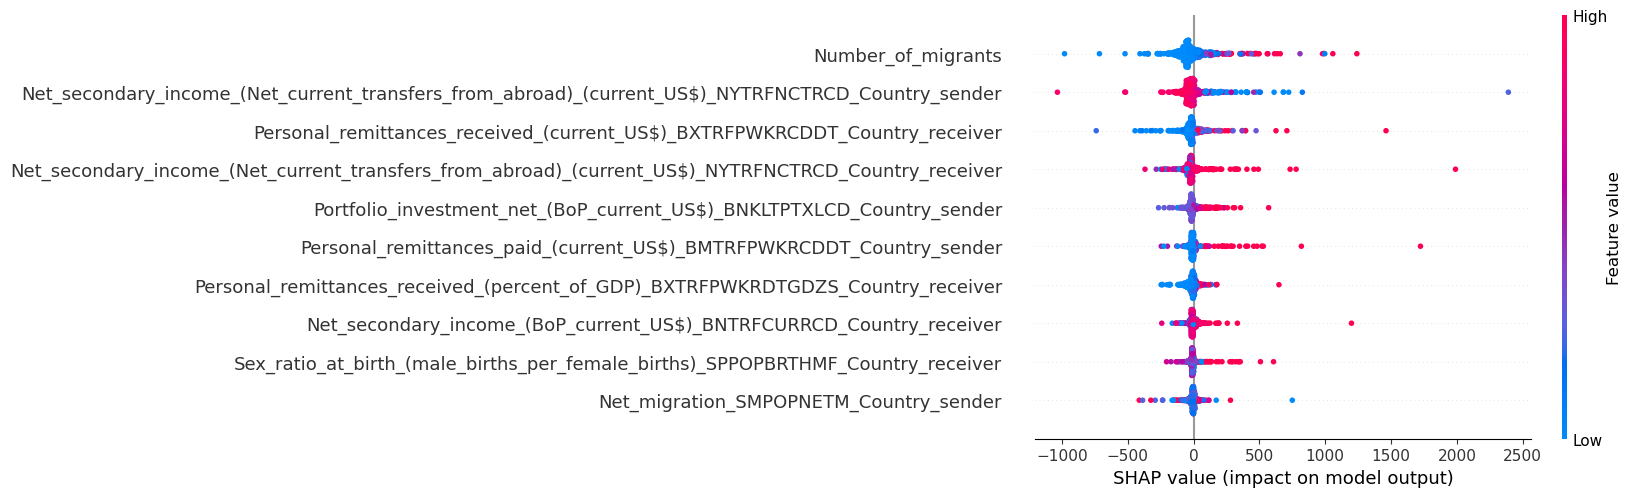

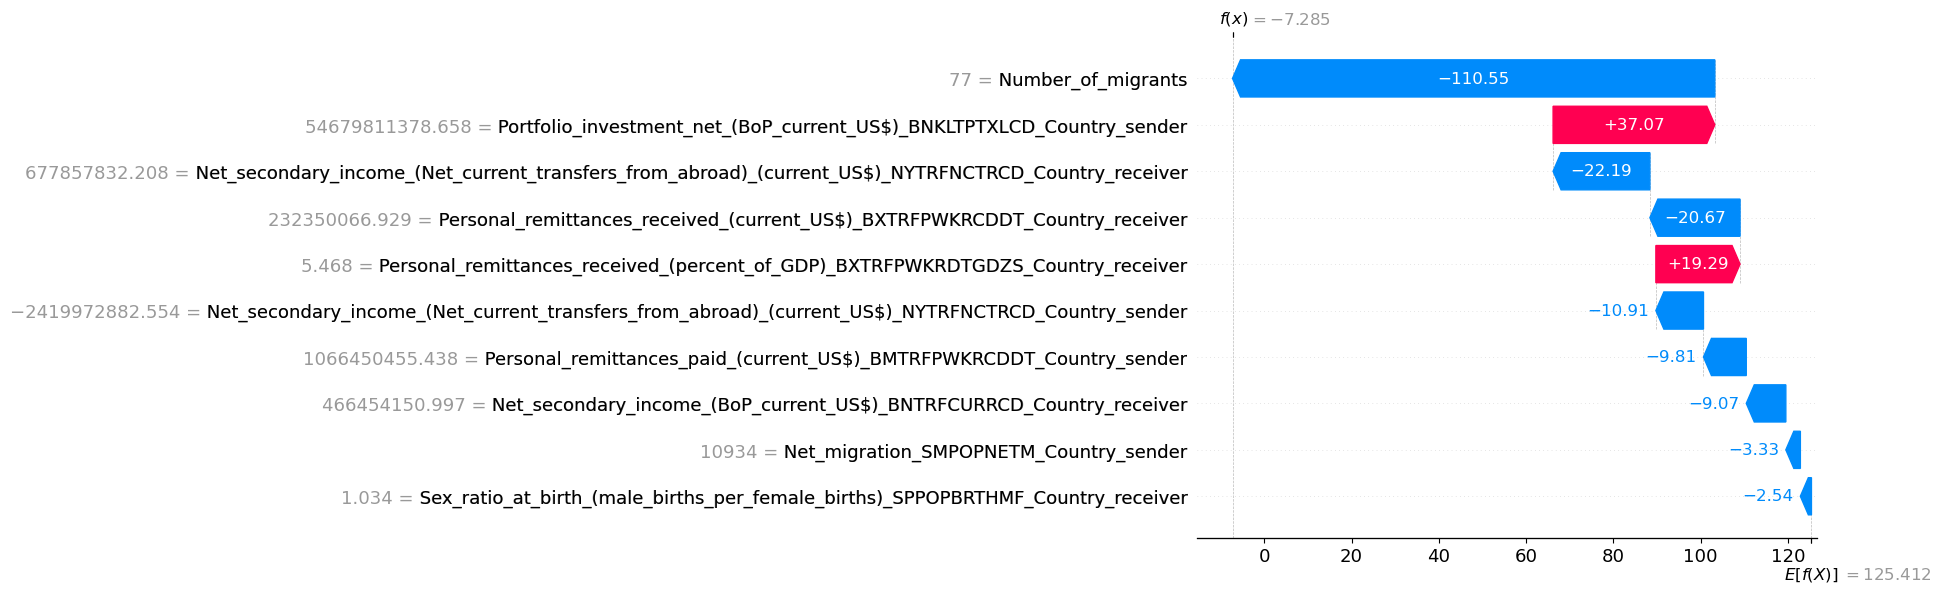

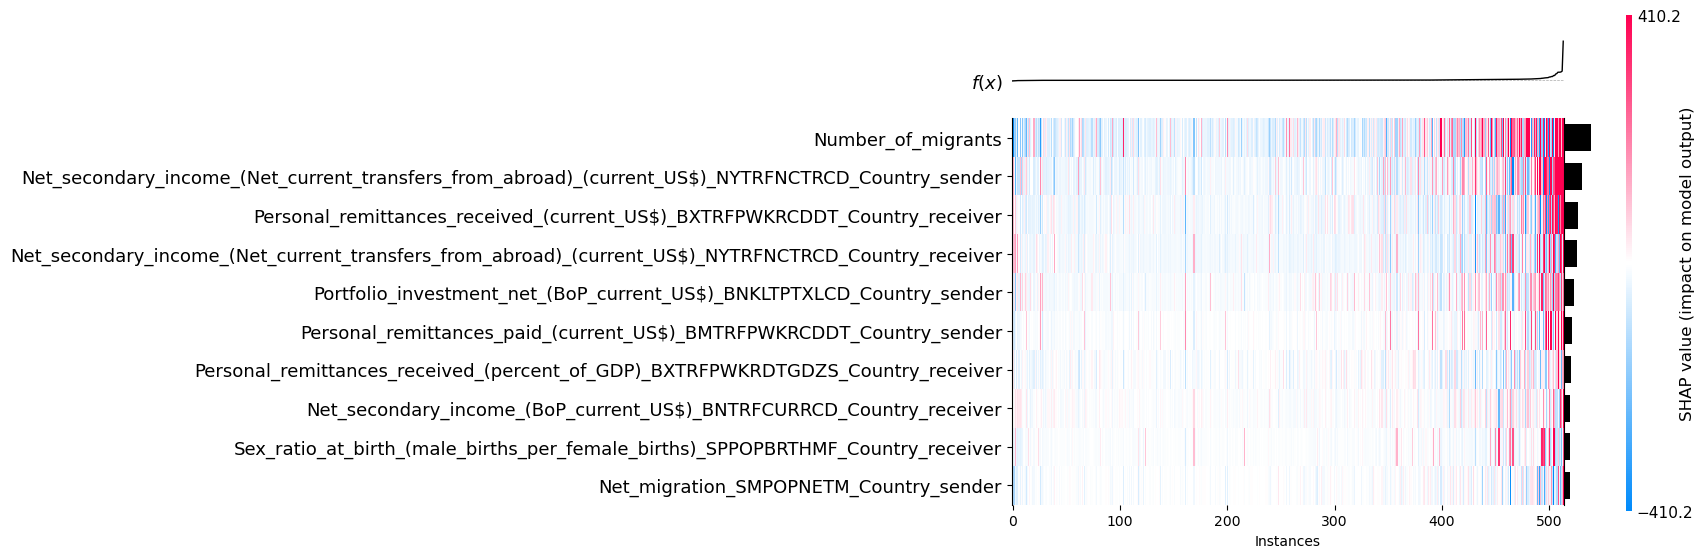

In [257]:
# Объяснение модели с помощью SHAP
explainer = shap.Explainer(Cat_boost_best)
shap_values = explainer(X_test_catboost)

# Визуализация SHAP summary plot
shap.summary_plot(shap_values, X_test_catboost)

# Визуализация SHAP waterfall plot для первого предсказания
shap.plots.waterfall(shap_values[0])

# order by predictions
order = np.argsort(y_pred_catboost)
shap.plots.heatmap(shap_values, instance_order=order)

# XGBoost regressor

In [262]:
# Целевая функция для Optuna
def objective(trial):
    # Определение гиперпараметров модели
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "random_state": 35
    }
    
    model = XGBRegressor(**param)
    
    # Обучение модели
    model.fit(X_train_catboost, y_train, eval_set=[(X_val_catboost, y_val)], early_stopping_rounds=100, verbose=False)
    
    # Предсказание и оценка модели
    y_pred = model.predict(X_val_catboost)
    return mean_squared_error(y_val, y_pred, squared=False)

# Создание и запуск Optuna-исследования
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

# Вывод лучших гиперпараметров
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Обучение модели с лучшими гиперпараметрами на полном тренировочном наборе
best_model = XGBRegressor(
    n_estimators=trial.params["n_estimators"],
    learning_rate=trial.params["learning_rate"],
    max_depth=trial.params["max_depth"],
    min_child_weight=trial.params["min_child_weight"],
    gamma=trial.params["gamma"],
    subsample=trial.params["subsample"],
    colsample_bytree=trial.params["colsample_bytree"],
    reg_alpha=trial.params["reg_alpha"],
    reg_lambda=trial.params["reg_lambda"],
    random_state=42
)

best_model.fit(X_train_catboost, y_train)

# Проверка модели на тестовом наборе
y_pred_xgb = best_model.predict(X_test_catboost)

print("XGBoost")
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_pred_xgb))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_xgb))
print("R^2: ", r2_score(y_test, y_pred_xgb))


[I 2024-05-27 07:47:31,362] A new study created in memory with name: no-name-86878651-cdbf-4667-b71f-8569ede4bea7
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:47:31,814] Trial 0 finished with value: 537.0417252821553 and parameters: {'n_estimators': 406, 'learning_rate': 0.04074988347096717, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.1177109857488937, 'subsample': 0.9603347100812927, 'colsample_bytree': 0.53631630144106, 'reg_alpha': 2.4608410246747303e-06, 'reg_lambda': 1.0161725474312236e-08}. Best is trial 0 with value: 537.0417252821553.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `earl

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:47:41,399] Trial 12 finished with value: 489.5133283141789 and parameters: {'n_estimators': 592, 'learning_rate': 0.09672359213126644, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.027353161312883324, 'subsample': 0.830919839311079, 'colsample_bytree': 0.6509232242333151, 'reg_alpha': 0.7187567719063054, 'reg_lambda': 56.323213599309504}. Best is trial 1 with value: 475.9007223640602.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:47:42,017] Trial 13 finished with value: 

[I 2024-05-27 07:47:48,900] Trial 24 finished with value: 477.3388306158323 and parameters: {'n_estimators': 520, 'learning_rate': 0.06283102489134033, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 1.1091180532230757e-05, 'subsample': 0.7569055438966681, 'colsample_bytree': 0.8682974564004342, 'reg_alpha': 1.3739259686284376e-05, 'reg_lambda': 0.0036741038368581958}. Best is trial 17 with value: 470.0265995016332.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:47:50,359] Trial 25 finished with value: 478.4451135887259 and parameters: {'n_estimators': 667, 'learning_rate': 0.018957006432561742, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 7.945321116589595e-07, 'subsample': 0.6768135230203228, 'colsample_bytree': 0.8253930161615398, 'reg_alpha': 0.0

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:47:59,937] Trial 37 finished with value: 510.3788010860913 and parameters: {'n_estimators': 719, 'learning_rate': 0.05520379865389301, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 2.8038728839863325e-06, 'subsample': 0.8097076141424234, 'colsample_bytree': 0.7425999199796756, 'reg_alpha': 0.06820229367011553, 'reg_lambda': 13.332456965378386}. Best is trial 26 with value: 468.15555207195.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:01,043] Trial 38 finished with value

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:05,545] Trial 49 finished with value: 468.159835280475 and parameters: {'n_estimators': 272, 'learning_rate': 0.09899340520112797, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.0015485505848974498, 'subsample': 0.821846880137142, 'colsample_bytree': 0.9965955726380011, 'reg_alpha': 1.336847263723538e-07, 'reg_lambda': 3.899029984191897e-06}. Best is trial 40 with value: 450.3800145923797.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:05,878] Trial 50 finished with 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:09,770] Trial 61 finished with value: 463.4506606692615 and parameters: {'n_estimators': 370, 'learning_rate': 0.08687220027240725, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.002186353629020884, 'subsample': 0.8252009254294257, 'colsample_bytree': 0.9980946014352369, 'reg_alpha': 8.675682757690139e-08, 'reg_lambda': 4.10639334218182e-06}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:10,246] Trial 62 finished with 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:15,743] Trial 73 finished with value: 470.5835767740932 and parameters: {'n_estimators': 398, 'learning_rate': 0.06468593845071355, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.0014488140065261638, 'subsample': 0.7833012772515522, 'colsample_bytree': 0.9650085577150564, 'reg_alpha': 4.68564345799633e-07, 'reg_lambda': 2.980971229138755e-05}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:16,221] Trial 74 finished with

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:21,587] Trial 85 finished with value: 483.0109395318357 and parameters: {'n_estimators': 320, 'learning_rate': 0.09042687854837353, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.004285898931886923, 'subsample': 0.8273804283775573, 'colsample_bytree': 0.6611555505463121, 'reg_alpha': 1.0219832175063717e-08, 'reg_lambda': 1.571893929646631e-07}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:22,101] Trial 86 finished wit

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:26,338] Trial 97 finished with value: 492.2831678139501 and parameters: {'n_estimators': 233, 'learning_rate': 0.06288800581069344, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.005652523900619427, 'subsample': 0.8737460420217427, 'colsample_bytree': 0.9570637909205311, 'reg_alpha': 1.4253808911850145e-07, 'reg_lambda': 0.002834994258290602}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:26,835] Trial 98 finished with

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:32,489] Trial 109 finished with value: 462.68981623629196 and parameters: {'n_estimators': 157, 'learning_rate': 0.0841232048052982, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.00015946375757508916, 'subsample': 0.824756303239873, 'colsample_bytree': 0.9405962494942803, 'reg_alpha': 5.261609403728304e-07, 'reg_lambda': 0.00011446421010622233}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:32,901] Trial 110 finished

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:39,393] Trial 121 finished with value: 478.50777965793185 and parameters: {'n_estimators': 514, 'learning_rate': 0.08166205057681626, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.0019134575046242048, 'subsample': 0.7937417570803761, 'colsample_bytree': 0.956359743252519, 'reg_alpha': 4.752962106070868e-06, 'reg_lambda': 2.5846340677902436e-05}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:40,249] Trial 122 finished

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:48,671] Trial 133 finished with value: 465.783560369568 and parameters: {'n_estimators': 655, 'learning_rate': 0.07573673291786545, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.608371864391492e-05, 'subsample': 0.804516174199104, 'colsample_bytree': 0.9895973078441088, 'reg_alpha': 6.920194289010927e-06, 'reg_lambda': 2.3779001664294966e-06}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:49,812] Trial 134 finished wi

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:48:59,731] Trial 145 finished with value: 457.7469056857545 and parameters: {'n_estimators': 740, 'learning_rate': 0.0646407693612044, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 7.951523024783923e-07, 'subsample': 0.8506282523662178, 'colsample_bytree': 0.8396119761317918, 'reg_alpha': 0.00031669961615811724, 'reg_lambda': 5.392588962201363e-07}. Best is trial 54 with value: 445.5671827090883.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:00,714] Trial 146 finished w

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:10,450] Trial 157 finished with value: 522.7011511821842 and parameters: {'n_estimators': 689, 'learning_rate': 0.06312056957444809, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 4.114413674081575e-06, 'subsample': 0.9331502428467325, 'colsample_bytree': 0.7929470475569589, 'reg_alpha': 0.00010722773829283217, 'reg_lambda': 7.35288847000569e-07}. Best is trial 146 with value: 444.2536885427874.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:11,191] Trial 158 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:19,910] Trial 169 finished with value: 448.6878930245004 and parameters: {'n_estimators': 685, 'learning_rate': 0.06710673717142793, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.5441208669144235e-06, 'subsample': 0.8567701883999891, 'colsample_bytree': 0.8399933065604971, 'reg_alpha': 0.00019526552011573964, 'reg_lambda': 8.310626766942393e-07}. Best is trial 146 with value: 444.2536885427874.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:20,515] Trial 170 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:28,402] Trial 181 finished with value: 456.6415639899605 and parameters: {'n_estimators': 713, 'learning_rate': 0.08507309353087952, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.8451380057947437e-06, 'subsample': 0.8322370695493622, 'colsample_bytree': 0.7961542883393393, 'reg_alpha': 9.614555232631219e-05, 'reg_lambda': 6.014663265036057e-08}. Best is trial 173 with value: 440.6295040611296.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:29,219] Trial 182 finished

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:37,983] Trial 193 finished with value: 449.4904660799583 and parameters: {'n_estimators': 929, 'learning_rate': 0.07355045961556539, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.515282781752022e-05, 'subsample': 0.8345644244277434, 'colsample_bytree': 0.8265743510729359, 'reg_alpha': 0.006400306434515603, 'reg_lambda': 2.7479015331842423e-06}. Best is trial 173 with value: 440.6295040611296.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:38,699] Trial 194 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:47,758] Trial 205 finished with value: 448.55299745635324 and parameters: {'n_estimators': 884, 'learning_rate': 0.05143762257693948, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.2740754982574595e-05, 'subsample': 0.8390205847958406, 'colsample_bytree': 0.8503878848207643, 'reg_alpha': 0.0022477672997829943, 'reg_lambda': 6.460842183709602e-06}. Best is trial 173 with value: 440.6295040611296.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:49:49,408] Trial 206 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:00,975] Trial 217 finished with value: 458.58257925523066 and parameters: {'n_estimators': 978, 'learning_rate': 0.0675340715800679, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 5.8985486553781536e-05, 'subsample': 0.8696809990134248, 'colsample_bytree': 0.8759992912821976, 'reg_alpha': 0.0006618149420604633, 'reg_lambda': 1.6443310565808248e-06}. Best is trial 173 with value: 440.6295040611296.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:01,757] Trial 218 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:09,774] Trial 229 finished with value: 461.5208319152456 and parameters: {'n_estimators': 875, 'learning_rate': 0.06389634004078193, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 7.216424310971274e-05, 'subsample': 0.8275900484538833, 'colsample_bytree': 0.8723948841240493, 'reg_alpha': 0.0037877142191290267, 'reg_lambda': 7.372530207458695e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:10,057] Trial 230 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:18,144] Trial 241 finished with value: 441.9498420609903 and parameters: {'n_estimators': 898, 'learning_rate': 0.07564179141989376, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 6.02292554349932e-05, 'subsample': 0.8458438896704502, 'colsample_bytree': 0.8218683031694067, 'reg_alpha': 0.0068870016301550785, 'reg_lambda': 5.917551678297863e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:19,288] Trial 242 finished w

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:30,053] Trial 253 finished with value: 446.0339007419764 and parameters: {'n_estimators': 891, 'learning_rate': 0.0532806739437388, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 1.4800385839279496e-05, 'subsample': 0.8250396917720726, 'colsample_bytree': 0.8361059781733428, 'reg_alpha': 0.010378464813972173, 'reg_lambda': 1.859208124196451e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:31,779] Trial 254 finished w

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:42,291] Trial 265 finished with value: 451.6459178835204 and parameters: {'n_estimators': 813, 'learning_rate': 0.06312331630847211, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.000349291047268305, 'subsample': 0.8521403418085928, 'colsample_bytree': 0.8397125431649018, 'reg_alpha': 0.0007654015493654198, 'reg_lambda': 2.1913857459036827e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:43,060] Trial 266 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:51,527] Trial 277 finished with value: 458.9664653150521 and parameters: {'n_estimators': 776, 'learning_rate': 0.027525726943385502, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.3855541159890278e-06, 'subsample': 0.857600517119549, 'colsample_bytree': 0.8526992240817828, 'reg_alpha': 0.049989930078415894, 'reg_lambda': 4.987806308566369e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:50:52,361] Trial 278 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:01,557] Trial 289 finished with value: 451.97417015041185 and parameters: {'n_estimators': 817, 'learning_rate': 0.08358118968265715, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.5297259590778362e-05, 'subsample': 0.8453128127982168, 'colsample_bytree': 0.8724140577908785, 'reg_alpha': 13.417051786299911, 'reg_lambda': 2.0238814828672727e-05}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:02,584] Trial 290 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:09,960] Trial 301 finished with value: 452.20737422848333 and parameters: {'n_estimators': 807, 'learning_rate': 0.07881300049453852, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 1.0049394234747545e-05, 'subsample': 0.8494055448155983, 'colsample_bytree': 0.8875224376769201, 'reg_alpha': 19.28656434681843, 'reg_lambda': 3.230361851172408e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:10,462] Trial 302 finished wi

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:17,992] Trial 313 finished with value: 579.7828394486565 and parameters: {'n_estimators': 917, 'learning_rate': 0.09971697058585635, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.737492539717331e-05, 'subsample': 0.8140373138225092, 'colsample_bytree': 0.8140645171832892, 'reg_alpha': 24.643394486890962, 'reg_lambda': 1.2050027737928126e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:18,748] Trial 314 finished wit

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:25,288] Trial 325 finished with value: 457.0578626652109 and parameters: {'n_estimators': 940, 'learning_rate': 0.072863132270509, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 1.972297010458172e-05, 'subsample': 0.8393578260604474, 'colsample_bytree': 0.8576532019582416, 'reg_alpha': 5.274332257232728e-07, 'reg_lambda': 2.45829624706465e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:26,249] Trial 326 finished wit

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:33,397] Trial 337 finished with value: 477.46806208214485 and parameters: {'n_estimators': 489, 'learning_rate': 0.07236011481878729, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.6804322042022606e-06, 'subsample': 0.8201481844202755, 'colsample_bytree': 0.8518428604719095, 'reg_alpha': 0.02157036968696874, 'reg_lambda': 3.293288070045494e-05}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:34,640] Trial 338 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:44,012] Trial 349 finished with value: 467.66160169131007 and parameters: {'n_estimators': 565, 'learning_rate': 0.07680980647615823, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.723503318641623e-05, 'subsample': 0.8390746548510273, 'colsample_bytree': 0.7966800379139302, 'reg_alpha': 0.017399138246487, 'reg_lambda': 1.5299722879726998e-05}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:44,868] Trial 350 finished wi

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:52,273] Trial 361 finished with value: 455.458325717859 and parameters: {'n_estimators': 977, 'learning_rate': 0.03453025184851906, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 5.051721930489701e-05, 'subsample': 0.8490704489919226, 'colsample_bytree': 0.8412799324992112, 'reg_alpha': 0.003598626195371653, 'reg_lambda': 5.6854226055650095e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:51:53,760] Trial 362 finished w

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:07,101] Trial 373 finished with value: 459.79948400896 and parameters: {'n_estimators': 902, 'learning_rate': 0.0503095494305608, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3.914321225034776e-06, 'subsample': 0.839413562422109, 'colsample_bytree': 0.834791585173231, 'reg_alpha': 0.013964735108300786, 'reg_lambda': 8.063402302132511e-08}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:07,981] Trial 374 finished with v

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:16,432] Trial 385 finished with value: 463.1320474813799 and parameters: {'n_estimators': 928, 'learning_rate': 0.09924702488522645, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 9.576776113672913e-06, 'subsample': 0.8449145492943628, 'colsample_bytree': 0.9354255556386317, 'reg_alpha': 0.005963136230131879, 'reg_lambda': 1.7332114658511034e-08}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:17,098] Trial 386 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:27,332] Trial 397 finished with value: 483.18193454003534 and parameters: {'n_estimators': 872, 'learning_rate': 0.06610370368416957, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 2.1952793182660533e-05, 'subsample': 0.7552215190157917, 'colsample_bytree': 0.8375784867703332, 'reg_alpha': 0.004518910865315488, 'reg_lambda': 3.8067306634014184e-08}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:28,642] Trial 398 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:39,935] Trial 409 finished with value: 463.57698388072953 and parameters: {'n_estimators': 592, 'learning_rate': 0.0631092627475352, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 6.655254688991025e-06, 'subsample': 0.8026245379448333, 'colsample_bytree': 0.8048939209319803, 'reg_alpha': 0.0912531688475647, 'reg_lambda': 7.422391469299566e-07}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:40,704] Trial 410 finished wit

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:49,312] Trial 421 finished with value: 453.23975490622246 and parameters: {'n_estimators': 708, 'learning_rate': 0.08166556190038098, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 5.6598412467151575e-05, 'subsample': 0.8271545489383076, 'colsample_bytree': 0.9794528003469674, 'reg_alpha': 7.284971201963629e-07, 'reg_lambda': 9.142729774248673e-07}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:50,464] Trial 422 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:52:59,695] Trial 433 finished with value: 464.4869549312415 and parameters: {'n_estimators': 309, 'learning_rate': 0.06878943827932815, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 1.9828187158564072e-05, 'subsample': 0.8541106319982772, 'colsample_bytree': 0.8534683702897895, 'reg_alpha': 0.02092395998410523, 'reg_lambda': 7.35736205291758e-07}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:01,625] Trial 434 finished wi

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:13,644] Trial 445 finished with value: 460.092718402174 and parameters: {'n_estimators': 863, 'learning_rate': 0.050792369463519754, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.00015333151191939792, 'subsample': 0.8246918923825154, 'colsample_bytree': 0.868169321682705, 'reg_alpha': 0.0006081476856867313, 'reg_lambda': 7.962937388780404e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:15,295] Trial 446 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:24,986] Trial 457 finished with value: 459.0390881742682 and parameters: {'n_estimators': 895, 'learning_rate': 0.06560771981756161, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.00014730960340749827, 'subsample': 0.8393150174631336, 'colsample_bytree': 0.8600973863429059, 'reg_alpha': 4.541635150992932e-06, 'reg_lambda': 1.1550720814545242e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:25,493] Trial 458 finishe

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:35,669] Trial 469 finished with value: 567.5880210030051 and parameters: {'n_estimators': 803, 'learning_rate': 0.06675135361985222, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 2.8960997849903885e-05, 'subsample': 0.8493627003844738, 'colsample_bytree': 0.8175787037902202, 'reg_alpha': 1.915843694053817e-06, 'reg_lambda': 5.628339222418088e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:36,835] Trial 470 finished 

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:47,274] Trial 481 finished with value: 451.50234741925914 and parameters: {'n_estimators': 747, 'learning_rate': 0.08009069686303973, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.00013287159579953428, 'subsample': 0.8423459035995473, 'colsample_bytree': 0.8221786757682472, 'reg_alpha': 0.01550079274531081, 'reg_lambda': 2.6083737873055504e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:47,846] Trial 482 finished

/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:55,954] Trial 493 finished with value: 453.45150100493834 and parameters: {'n_estimators': 504, 'learning_rate': 0.07871059132517239, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 4.2830218130420615e-05, 'subsample': 0.8150595083444805, 'colsample_bytree': 0.818750857551055, 'reg_alpha': 0.003336454029620109, 'reg_lambda': 3.912248719807444e-06}. Best is trial 218 with value: 439.0866278752903.
/Users/artemsmirnov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-05-27 07:53:56,436] Trial 494 finished 

Best trial:
  Value: 439.0866278752903
  Params: 
    n_estimators: 918
    learning_rate: 0.07491959818079777
    max_depth: 9
    min_child_weight: 10
    gamma: 3.460498556906873e-05
    subsample: 0.8494330486344133
    colsample_bytree: 0.8483743997437986
    reg_alpha: 0.0014217176895627399
    reg_lambda: 1.8500924010028157e-06
XGBoost
 
MAE:  141.23622408670136
MAPE: 73.53857324846675
R^2:  0.33298703411633457


In [264]:
XG_boost_best = XGBRegressor(
    n_estimators = 158,
    learning_rate = 0.09293252882916091,
    max_depth = 9,
    min_child_weight = 9,
    gamma = 1.0627044384970583,
    subsample = 0.5962963425800003,
    colsample_bytree = 0.9942586359790203,
    reg_alpha = 0.15684426644572597,
    reg_lambda = 4.1738703216835075e-07,
    random_state = 11
)

XG_boost_best.fit(X_train_catboost, y_train)


# Проверка модели на тестовом наборе
y_pred_xgb = XG_boost_best.predict(X_test_catboost)

print("XGBoost")
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_pred_xgb))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_xgb))
print("R^2: ", r2_score(y_test, y_pred_xgb))

XGBoost
 
MAE:  118.59896092173263
MAPE: 64.45506582178298
R^2:  0.5529158789198628


In [259]:
# Нормализация данных
scaler = StandardScaler()

# Нормализация данных для CatBoost
X_train_catboost_norm = scaler.fit_transform(X_train_catboost)
X_val_catboost_norm = scaler.transform(X_val_catboost)
X_test_catboost_norm = scaler.transform(X_test_catboost)

# Создание объекта линейной регрессии
linear_regression = LinearRegression()

# Обучение модели на нормализованных данных для CatBoost
linear_regression.fit(X_train_catboost_norm, y_train)
y_pred_lr = linear_regression.predict(X_test_catboost_norm)

# Вывод метрик качества модели
print("Linear Regression on Normalized CatBoost Data")
print(" ")
print("MAE: ", mean_absolute_error(y_test, y_pred_lr))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_lr))
print("R^2: ", r2_score(y_test, y_pred_lr))

Linear Regression on Normalized CatBoost Data
 
MAE:  261.7610013397913
MAPE:  995.2675955865957
R^2:  0.015323155677098854
